In [1]:
import cv2
import matplotlib.pylab as plt
import numpy as np
import sdc.image_processing.feature_extraction as fe
import sdc.image_processing.feature_extraction_settings as fes
from scipy.ndimage.measurements import label
import sdc.image_processing.helpers as hlp
from sdc.image_processing.helpers import visualize
import sdc.detection.svm_classifier as sc
import sdc.detection.object_detection as od
import sdc.detection.heatmap as h
import importlib


%matplotlib inline

training_non_vehicles = [
    'training_data/non-vehicles/Extras/extra1.png',
    'training_data/non-vehicles/Extras/extra2.png',
    'training_data/non-vehicles/Extras/extra3.png',
    'training_data/non-vehicles/Extras/extra4.png',
    'training_data/non-vehicles/Extras/extra5.png',
    'training_data/non-vehicles/Extras/extra6.png'
]

training_vehicles = [
    'training_data/vehicles/GTI_Far/image0000.png',
    'training_data/vehicles/GTI_Left/image0009.png',
    'training_data/vehicles/GTI_MiddleClose/image0000.png',
    'training_data/vehicles/GTI_Right/image0000.png',
    'training_data/vehicles/KITTI_extracted/1.png',
    'training_data/vehicles/GTI_MiddleClose/image0002.png'
]

example_images = [
    'test_images/test1.jpg', 
    'test_images/test2.jpg',
    'test_images/test3.jpg',
    'test_images/test4.jpg',
    'test_images/test5.jpg',
    'test_images/test6.jpg'
    ]
            
def read_file(fname):
    img = cv2.imread(fname)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def read_files(flist):
    images = []
    for f in flist:
        images.append(read_file(f))
    return images

def hog_features(images):
    hog_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        _, hog_vis = fe.get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
        hog_images.append(hog_vis)
    return hog_images


The  final video can be found [Here](https://youtu.be/XlZunXxhPKE)

# Vehicle tracking

This project goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4).

## The project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Perform color transform and append binned color features
* Addad histograms of color
* Combine all feature vectors along with HOG feature vector.
* Normalize the all feature vectors
* Estimate a bounding box for vehicles detected.
* Implement a sliding-window technique and use on the trained classifier to search for vehicles in images.

Initially experiments were performed on the test.video.mp4 video stream and later implement on full project_video.mp4.

### Exploring the training data

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples which I used to train my classifier. These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/).

Training set was split into 80% training data and 20% testing data:

<pre>
Total images: 17760
Total number of vehicles: 8792
Total number of non vechicles: 8968

Training set: 14208
Testing set: 3552
</pre>

There are some examples provided in test_images folder for testing the algorithm and processed results saved into output folder.




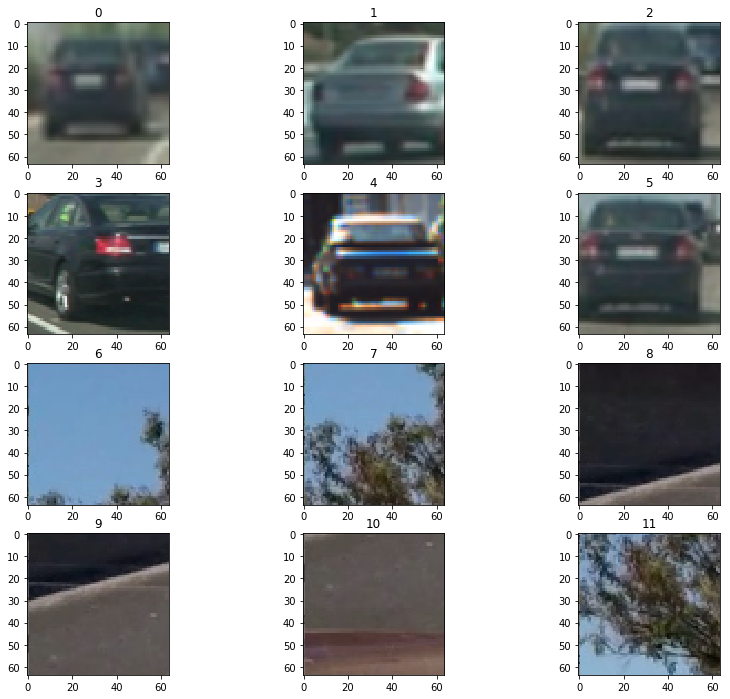

In [2]:
fig = plt.figure(figsize=(14, 12))
images = read_files(training_vehicles + training_non_vehicles)
visualize(fig, 4, 3, images, range(12))

#### Some test images

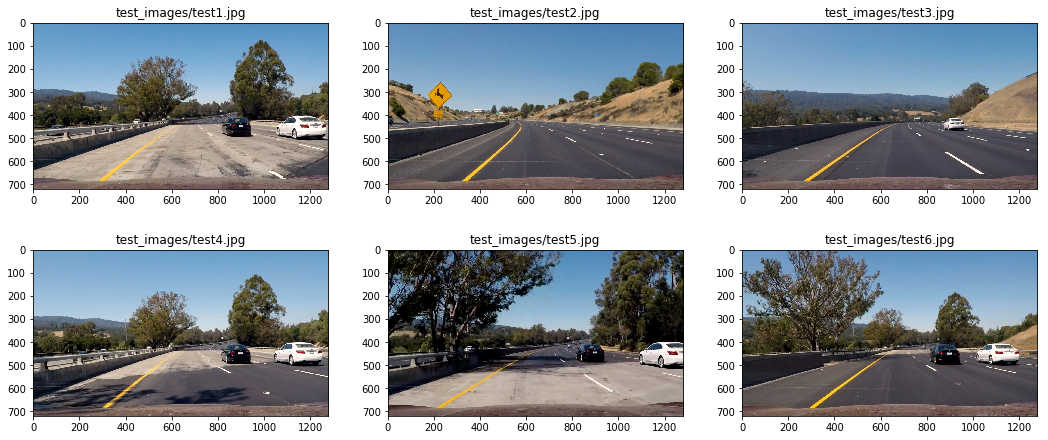

In [3]:
images = read_files(example_images)
fig = plt.figure(figsize=(18, 16))
visualize(fig, 4, 3, images, example_images)

## Feature extraction

### Histogram of Oriented Gradients (HOG)

The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image. This method is similar to that of edge orientation histograms, scale-invariant feature transform descriptors, and shape contexts, but differs in that it is computed on a dense grid of uniformly spaced cells and uses overlapping local contrast normalization for improved accuracy.
Here is some examples on test data

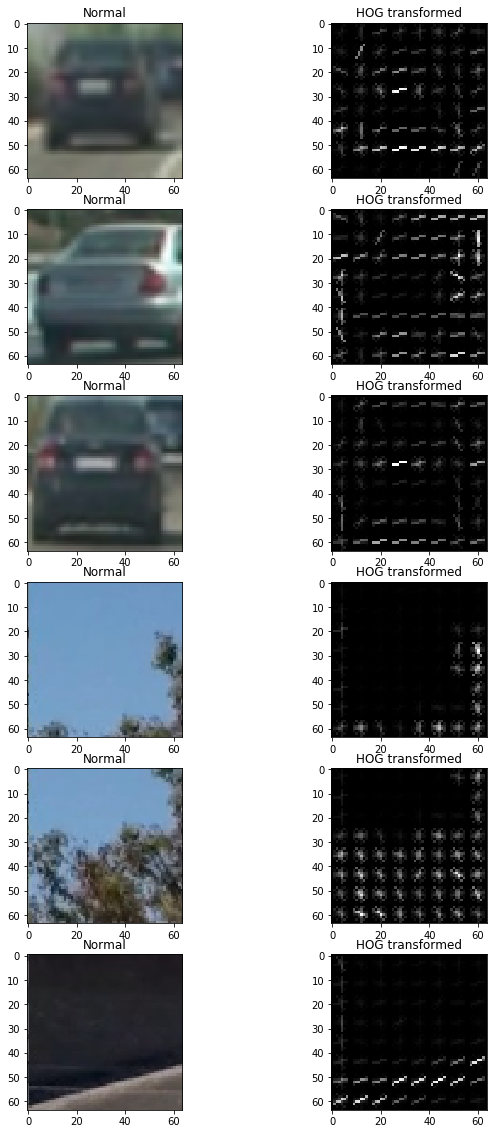

In [4]:
img_for_hog = training_vehicles[0:3] + training_non_vehicles[0:3]
images = read_files(img_for_hog)

hog_images = hog_features(images)
both, titles = [], []
for idx, img in enumerate(images):
    both.append(img)
    both.append(hog_images[idx])
    titles.append('Normal')
    titles.append('HOG transformed')
fig = plt.figure(figsize=(10, 20))
visualize(fig, 6, 2, both, titles, cmap='gray')

### Parameters for HOG

Parameters were chosen based on trial and error. I have tried different approaches and considering speed and accuracy I have chosen the following settings:

<pre>
Orientation: 9
Cells per block: 2
Pixel per cell: 8
</pre>

Increasing or decreasing orientation from 7 to 12 does not give any benefits. Increasing number of pixels per cell leads to poorer performance and less accuracy. So this combination of parameters worked best

### Colour histogram features

The other source of features I used is histograms of pixel intensity (color histograms) as features. I used all three channels to generate histogram and vectorize everything. With some experimentation I found that converting to **UCrCb** works best with least false positives. **LAB** and **LUV** colour spaces also did a great job, however it gave more false positive. I also tried **HSV**, **YUV** and **HLS** but those spaces gave too much false positives

Here is an example of different colour spaces

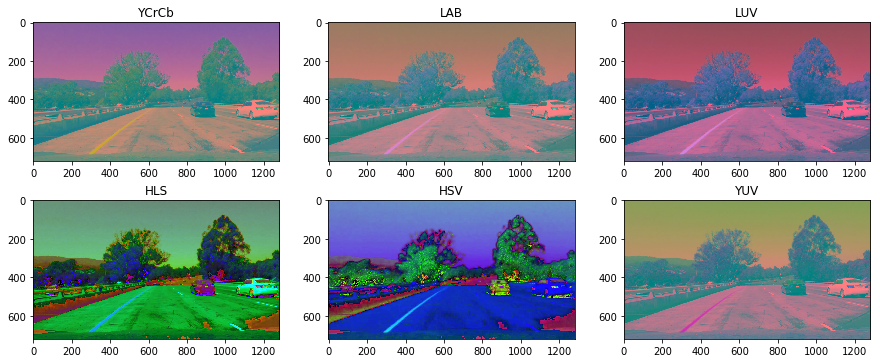

In [5]:
image = read_file(example_images[0])
images, spaces = [], ['YCrCb', 'LAB', 'LUV', 'HLS', 'HSV', 'YUV']
for space in spaces:
    conv_img = hlp.convert_to_color_space(image, space)
    images.append(conv_img)

fig = plt.figure(figsize=(15, 6))
visualize(fig, 2, 3, images, spaces)

### Spatial binning

Finally the last source of features comes from raw pixel. It is quite useful to include in my feature vector in searching for cars. First, I resized image to (32, 32) to make it smaller vector but enough to retain the information. Since classifier did a good job I decided not to invest more time in tweaking parameters but it is something worth trying in the future like changing colour spaces using only one channel making even smaller image etc.

## Training classifier

All features combined gave me 8460 feature vector for each training sample. The feature vector variance as expected is high because features are combined from different domain, thus feature normalization as in any machine learning application is needed for good results. I used Python's sklearn package which provides [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method to accomplish this task by standardizing features by removing the mean and scaling to unit variance. My choice of classifier was [Linear Support Vector Machine](https://en.wikipedia.org/wiki/Support_vector_machine).
Training process was quite fast but feature extraction took bit longer. In total it took around 77 secconds to extract features, apply scaler and train SVM

<pre>
Accuracy: 0.9932432432432432
Took time to train: 77 seconds
</pre>

The full ipython notebook can be found in [training.ipynb](training.ipynb)

## Detecting vehicles

First, the images are large enough and really we don't need such resolution, therefore I decided to resize it in half from (720, 1280) to (360, 640). Also, we don't need to search for vehicles over the whole image. Cropping out the area of interest from the whole image will speed up detection and reduce the number of false positives. I choose to use only x axis from 330 to 640 and y axis from 200 to 330.

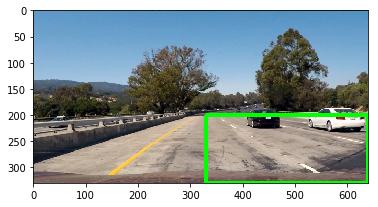

In [6]:
image = read_file(example_images[0])
image = cv2.resize(image, (640, 330))
cv2.rectangle(image, (330, 200), (640, 330), (0,255,0), 5)
plt.imshow(image)

The area is rather small and X axis should be extended, but for this case it works well. And my goal is to balance between quality and performance

### Sliding window

To detect vehicles in the image I implemented sliding window technique to search accross the area of interest. The window size I chose is 64 pixels. The number of steps is calculated:

<pre>
imshape = converted_img.shape
nxblocks = (imshape[1] // pix_per_cell) - 1
nyblocks = (imshape[0] // pix_per_cell) - 1

nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
nysteps = (nyblocks - nblocks_per_window) // cells_per_step
</pre>
Here **pix_per_cell = 8, cells_per_step = 2**. So it makes **60** windows in total.

The code is defined in [sdc.detection.object_detection.py](object_detection.py) starting from line 28

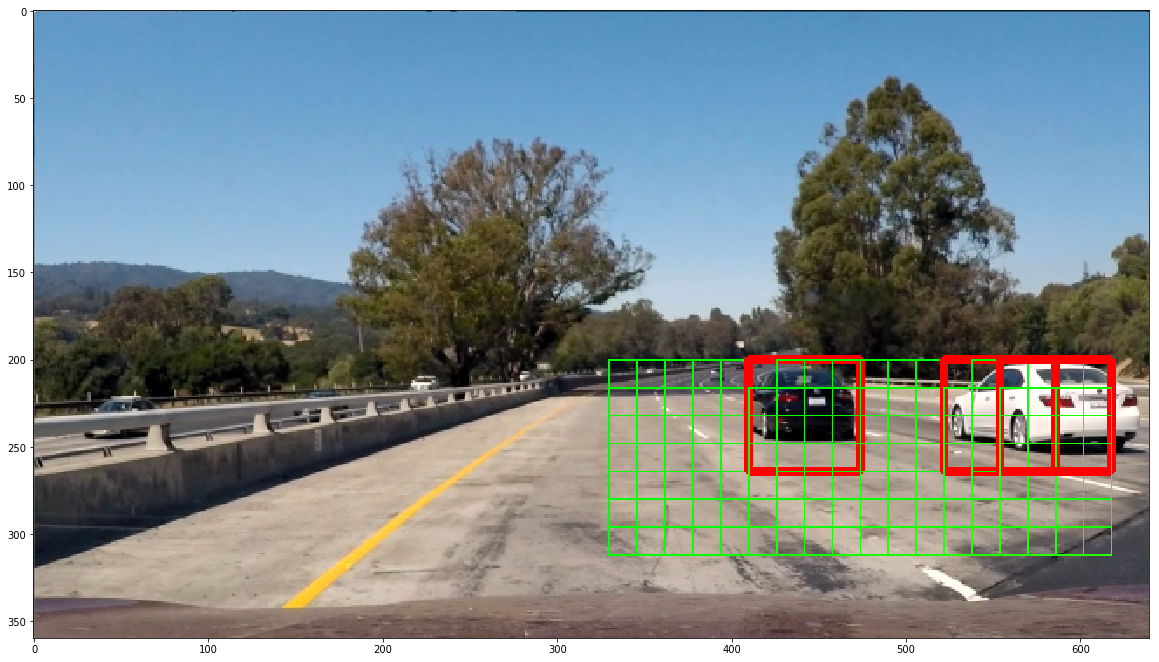

In [7]:
importlib.reload(od)

settings = fes.FeatureExtractionSettings()
classifier = sc.SVMClassifier(settings)
classifier.load()

detector = od.ObjectDetection(classifier)

detector.settings.xregion = (330, image.shape[1])
detector.settings.yregion = (200, 330)
detector.settings.scale = 1

fig = plt.figure(figsize=(20, 20))
image = read_file(example_images[0])
image = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2))
draw_img, _ = detector.find_objects(image, visualize_sliding_window=True)
plt.imshow(draw_img)

However that isn't good enough so I also use scaling factor, which basically enlarges HOG transformed image making searching space larger.
In my case the image is scaled by **0.7**. So, that makes image dimensions from **320x130** to **457x185** and number of windows increases to **168**

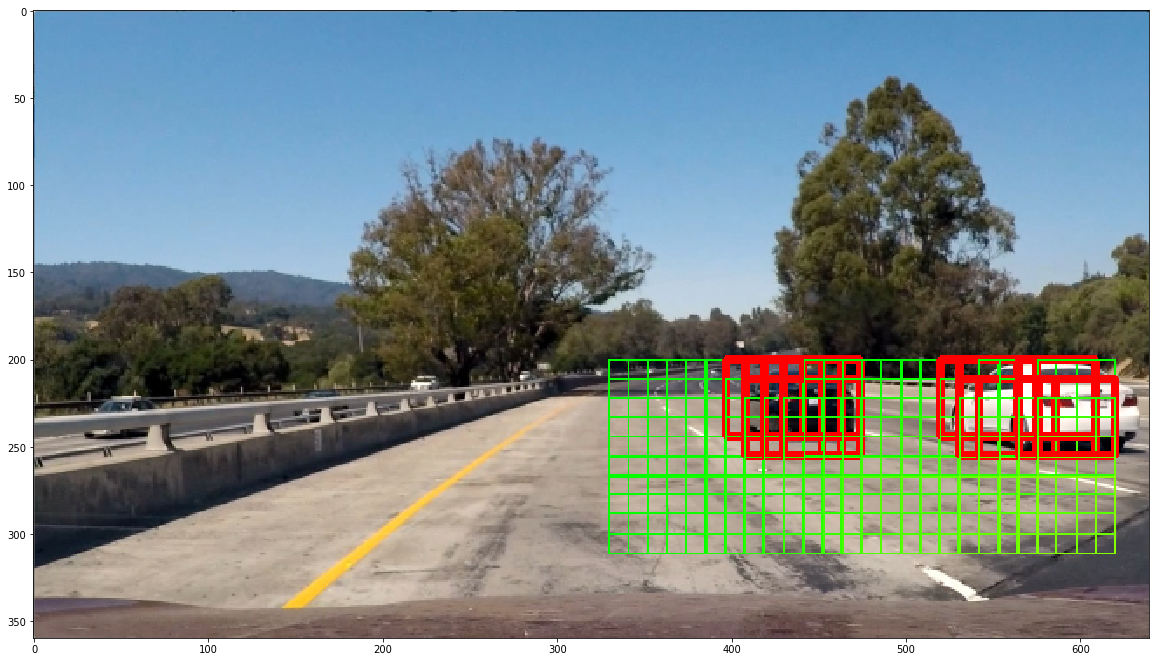

In [8]:
detector.settings.scale = 0.7
image = read_file(example_images[0])
image = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2))
draw_img, boxes = detector.find_objects(image, visualize_sliding_window=True)
fig = plt.figure(figsize=(20, 20))
plt.imshow(draw_img)

### Heatmap

Some windows are overlaping and in some areas we get false positive. In order to combine overlapping detections and remove false positives I build a heatmap. To make a heat-map, I simply add "heat" (+=1) for all pixels within windows where a positive detection is reported by classifier. The functionality of the heatmap is implemented in file [sdc.detection.heatmap.py](heatmap.py) 

The individual heat-maps for the above images look like this:

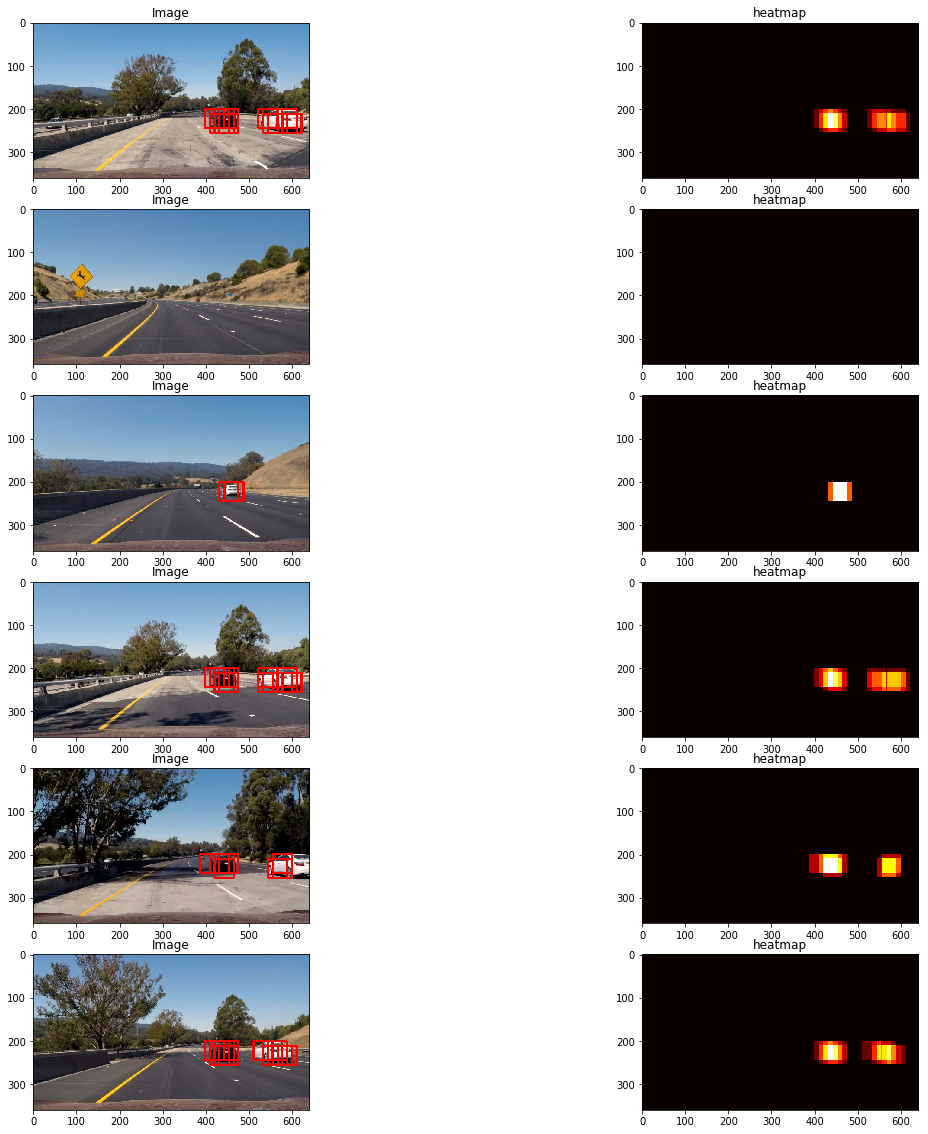

In [9]:
images, titles = [], []

for img_fn in example_images:
    image = read_file(img_fn)
    image = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2))
    draw_img, boxes = detector.find_objects(image, visualize_sliding_window=False)
    heatmap = h.DynamicHeatmap(draw_img.shape)
    heat = heatmap.add_heat(boxes)
    images.append(draw_img)
    images.append(heat)
    titles.append('Image')
    titles.append('heatmap')
    
fig = plt.figure(figsize=(20, 20))    
visualize(None, 6, 2, images, titles)

### Labelling objects

Althought I have experimented with different approaches and different thresholding to convert heatmap to binary mask. In the end I decided to take different approach. The heatmap isn't really required in my approach because I am using every point which is larger than 0. That means I don't need to setup any threshold. So, basically every point is already "included" when labelling.
Using binary image I then label each detected object with [label()](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html) method. Which helps me to get the boundaries of the object.
Here is an example of the labelled objects

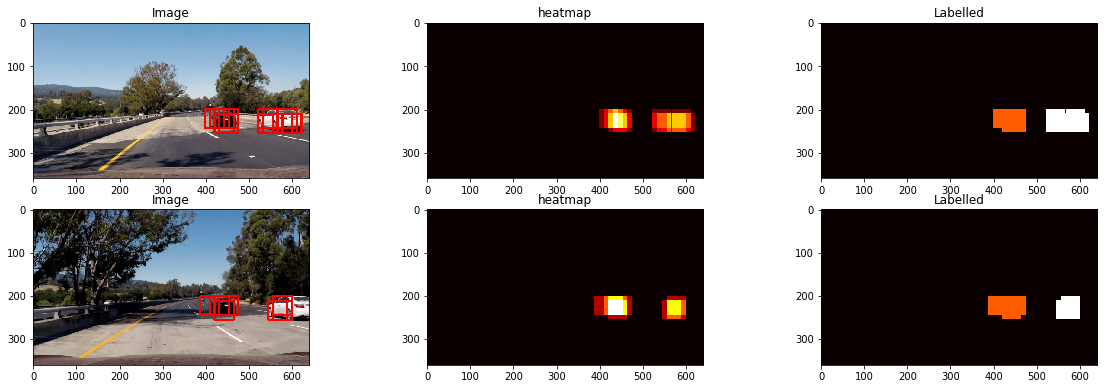

In [10]:
images, titles = [], []

for img_fn in example_images[3:5]:
    image = read_file(img_fn)
    image = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2))
    draw_img, boxes = detector.find_objects(image, visualize_sliding_window=False)
    heatmap = h.DynamicHeatmap(draw_img.shape)
    heat = heatmap.add_heat(boxes)
    binary_mask = np.copy(heat)
    binary_mask[binary_mask > 0] = 1
    labelled = label(binary_mask)
    images.append(draw_img)
    images.append(heat)
    images.append(labelled[0])
    titles.append('Image')
    titles.append('heatmap')
    titles.append('Labelled')
    
fig = plt.figure(figsize=(20, 20))    
visualize(None, 6, 3, images, titles, cmap='hot')

### Getting rid of false positive

I have tried different approaches on how to remove false positive like averaging heatmap over number of frames which should remove accidently appearing on a single frame, however it requires tunning threshold parameter. Instead of averaged heatmap I decided to apply **bitwise_and** operation between previous frame and current frame, and that works well.

### Merging boxes

There is one more problem left to sort out. If vehicle is close enough it takes a lot of spaces the classifier identifies "correctly" different places of vehicle, however during labelling step I get 2 or even more labelled objects but it should be treated as one. Here is illustrative example what could happen:

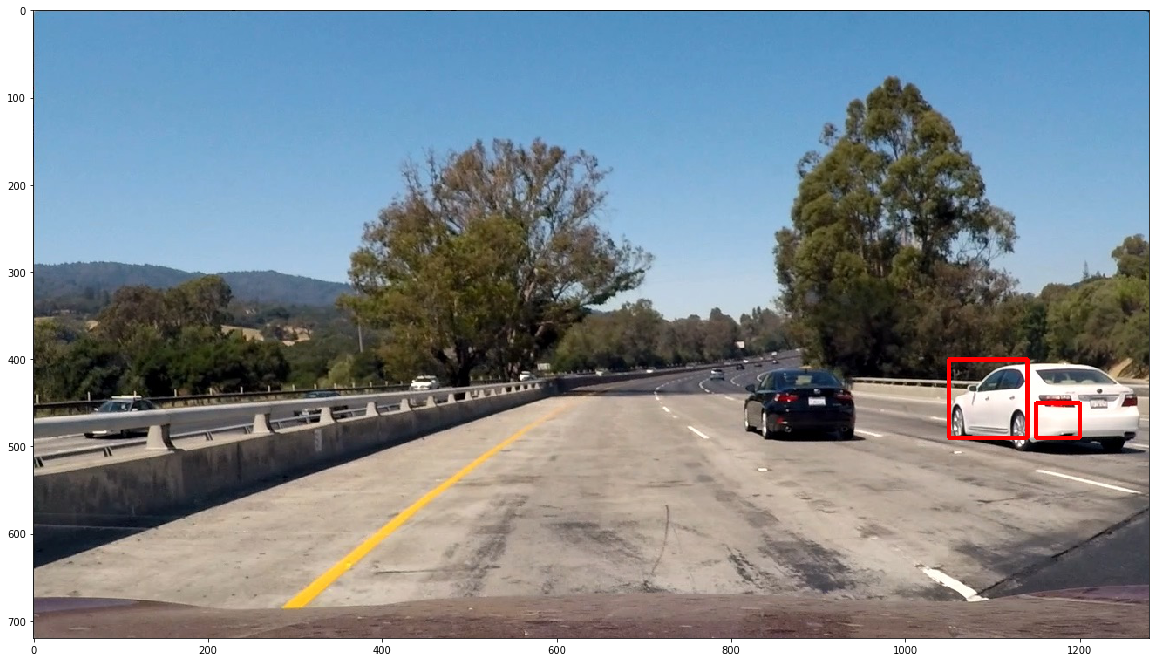

In [11]:
image = read_file(example_images[0])
plt.figure(figsize=(20,20))
cv2.rectangle(image, (1050, 400), (1140, 490), (255,0,0), 3)
cv2.rectangle(image, (1150, 450), (1200, 490), (255,0,0), 3)
plt.imshow(image)

Clearly this belongs to the same vehicle, but labelled as separate objects. To solve this problem I use expand and relabel techinque. It works in the following way, on the binary mask I redraw rectangles with slightly expanded borders by 10 pixels. So the result might look like this:

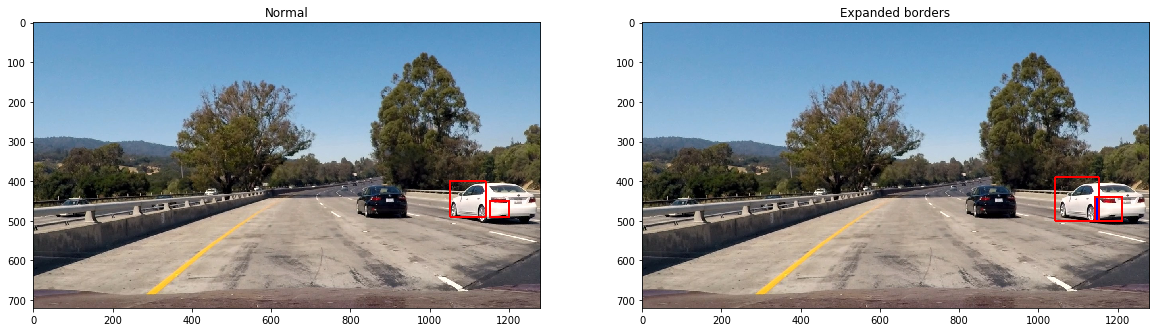

In [12]:
image1 = read_file(example_images[0])
fig = plt.figure(figsize=(20,20))
cv2.rectangle(image1, (1140, 440), (1150, 500), (0,0, 255), -1)
cv2.rectangle(image1, (1040, 390), (1150, 500), (255,0,0), 3)
cv2.rectangle(image1, (1140, 440), (1210, 500), (255,0,0), 3)
images, titles = [image, image1], ['Normal', 'Expanded borders']
visualize(fig, 1, 2, images, titles)

And relabel objects again. Those boxes are now detected as single objects. That solves the problem

### Pipeline

And finally I put everything together in pipeline. Now, the challenge is to find the balance between performance and quality. After some experimentation I choose to use only 10th frame and for the rest  just draw the previously detected borders. This works well with getting rid of false positive, since I use **bitwise_and** operation every 10th frame and incorrectly detected areas will likely disappear and ofcourse skipping 9 frames boosts the performance. The **project_video** was processed in than **38 seconds** that is even less than actuall video which is **51 second** !

pipeline notebook file can be found [here](pipeline.ipynb)

## Weakness of the algorithm

The strength of the implementation I believe is fast performance it processes video much faster than the length of actual video. However there are some issues with this:

* The parameters are fine-tuned for the project video but I see there could problems with other videos.
* Monitored area is very small compared with actual image. 
* Ignoring 9 frames can be a problem if vehicles are moving fast or quickly stopping. 
* The captured box is jumping and actual size of the car is not captured well.
* There is no proper mechanism for tracking vehicle between frames.
* The image is resized by half, so vehicles which are further away will not be detected

Instead of SVM I have tried to classify same features using neural network implementation instead. The results were not so impressive as I expected, but since it was not a requirement I decided not to invest much time in tunning the architecture of the neural network and tweaking the hyper parameters. Also, the performance of predictions were much slower than SVM, but I guess this is a problem with implementation in Keras. 

Final results can be found [here](https://youtu.be/XlZunXxhPKE)